We want our model to accurately measure the fraction of comments that are attacks for a group of comments. In this notebook we explore both model calibration and picking a threshold on the dev set and measure the reliability of our model on the test set.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from serialization import load_pipeline
from baselines import load_comments_and_labels, assemble_data
from sklearn.metrics import roc_curve, brier_score_loss, log_loss, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

Using TensorFlow backend.


In [2]:
# load data
task = 'attack'
data = load_comments_and_labels(task)

In [3]:
#load model trained on train split
model_name = 'linear_char_ed_train'
model_type = 'linear_char_ed'
path = '../../models/%s/%s' % (task, model_type)
model =  load_pipeline(path, model_name)

In [4]:
# train calibrator on dev set, eval done on test
# all data comes from data sampled at random

from sklearn.linear_model import LogisticRegression as LR
from sklearn.isotonic import IsotonicRegression as IR

X_dev, y_dev = assemble_data(data, 'comments', 'plurality', splits = ['dev'], samples = ['random'])
X_test, y_test = assemble_data(data, 'comments', 'plurality', splits = ['test'], samples = ['random'])

y_dev_pred = model.predict_proba(X_dev)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

### Model calibration

In [5]:
lr_calibrator = LR().fit( y_dev_pred.reshape( -1, 1 ), y_dev )                                                       
ir_calibrator = IR( out_of_bounds = 'clip' ).fit( y_dev_pred, y_dev )

In [6]:
y_test_pred_lr_calibrated = lr_calibrator.predict_proba( y_test_pred.reshape( -1, 1 ))[:,1]
y_test_pred_ir_calibrated = ir_calibrator.transform( y_test_pred ) 

In [7]:
# plot calibration transformations 

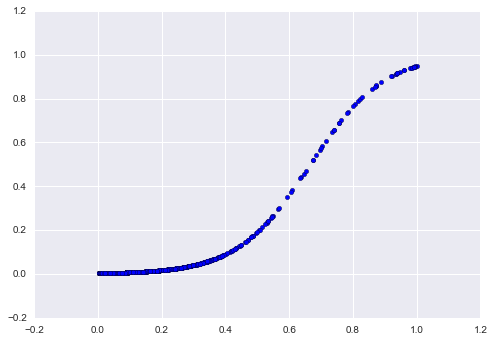

In [8]:
plt.scatter(y_test_pred, y_test_pred_lr_calibrated)

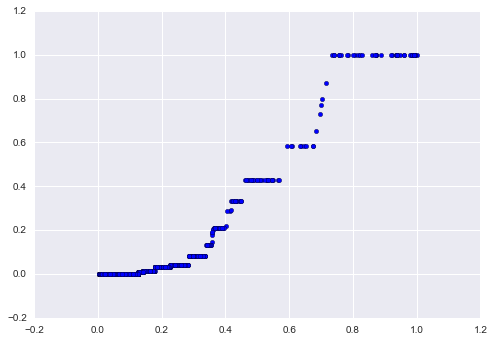

In [9]:
plt.scatter(y_test_pred, y_test_pred_ir_calibrated)

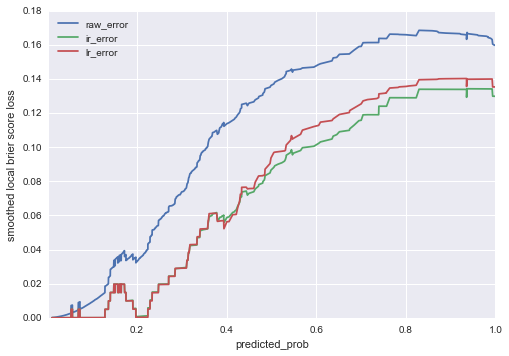

In [10]:
df_brier = pd.DataFrame()
df_brier['predicted_prob'] = y_test_pred
df_brier['raw_error'] = (y_test - y_test_pred)**2
df_brier['ir_error'] = (y_test - y_test_pred_ir_calibrated)**2
df_brier['lr_error'] = (y_test - y_test_pred_lr_calibrated)**2
df_brier = df_brier.sort_values('predicted_prob')
df_brier.index = df_brier['predicted_prob']
df_brier = pd.rolling_mean(df_brier[['raw_error', 'ir_error', 'lr_error']], 200)
df_brier.plot()
plt.ylabel('smoothed local brier score loss')

In [11]:
# see how well model scores can be used to infer attack rates for each calibrator

def plot_attack_rates(y, y_pred):
    
    print('brier_score_loss: ',  brier_score_loss(y, y_pred))
    print('log_loss: ',  log_loss(y, y_pred))
    print('roc_auc_score: ',  roc_auc_score(y, y_pred))
        
    true_rate = y.mean()
    expected_rate = y_pred.mean()
    print('true_rate: ', true_rate, ' expected_rate: ', expected_rate)
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    rates = [true_rate * tpr[i] + (1-true_rate) * fpr[i] for i in range(len(thresholds))]
    
    plt.plot(thresholds, rates, label='threshold rate')
    plt.plot(thresholds, [true_rate] * len(rates), label='true rate')
    plt.plot(thresholds, [expected_rate] * len(rates), label='expected rate')
    plt.ylabel('attack rate')
    plt.xlabel('threshold')
    plt.ylim((true_rate - 2.0*true_rate, true_rate + 2.0*true_rate))
    plt.legend()
    plt.xlim(0.0, 0.6)

brier_score_loss:  0.0104372378311
log_loss:  0.0749894085529
roc_auc_score:  0.981287335638
true_rate:  0.00948196114709  expected_rate:  0.0690152


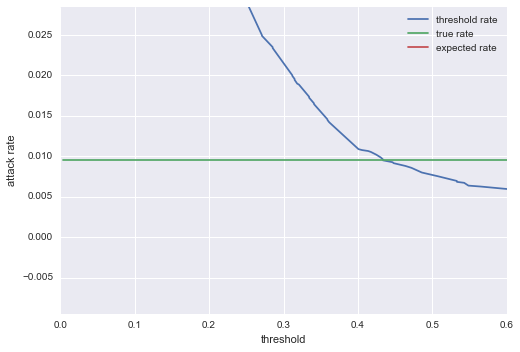

In [12]:
#no calibration
plot_attack_rates(y_test, y_test_pred)

brier_score_loss:  0.00471483816757
log_loss:  0.0368245004985
roc_auc_score:  0.978369532411
true_rate:  0.00948196114709  expected_rate:  0.0108583374526


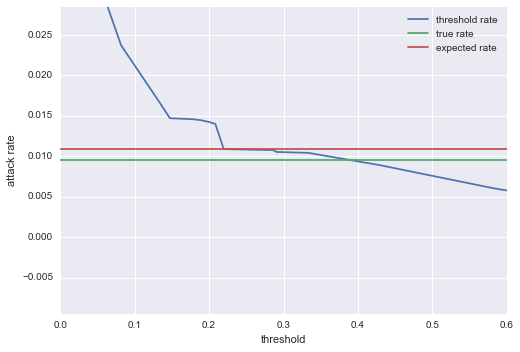

In [13]:
# isotonic regression calibration
plot_attack_rates(y_test, y_test_pred_ir_calibrated)

brier_score_loss:  0.00485288803301
log_loss:  0.0228516631178
roc_auc_score:  0.981287335638
true_rate:  0.00948196114709  expected_rate:  0.0115423619033


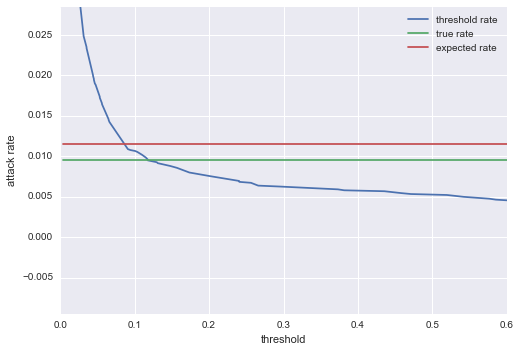

In [14]:
# logistic regression calibration
plot_attack_rates(y_test, y_test_pred_lr_calibrated)

### What about picking a threshold on the dev set?

In [15]:
true_rate = y_dev.mean()
thresholds = sorted(y_dev_pred)

In [16]:
rates = [(y_dev_pred > t).mean() for t in thresholds]

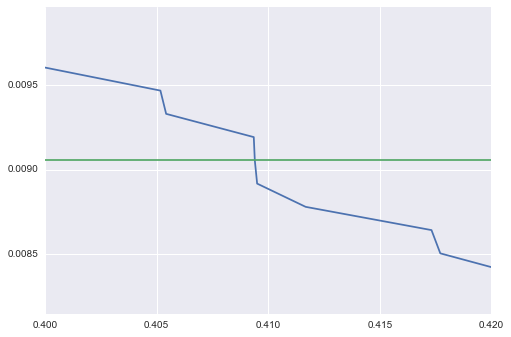

In [17]:
plt.plot(thresholds, rates)
plt.ylim((true_rate - 0.1*true_rate, true_rate + 0.1*true_rate))
plt.xlim((0.4, 0.42))

plt.plot(thresholds, [true_rate] * len(rates), label='true rate')

In [18]:
dev_er_t = 0.408

In [19]:
y_test.mean()

0.0094819611470860314

In [20]:
(y_test_pred > dev_er_t).mean()

0.010638297872340425

In [22]:
from stats_utils import bayesian_rate_interval
num_attacks = y_test.sum()
num_comments = y_test.shape[0]
bayesian_rate_interval(num_attacks, num_comments, conf=95, plot =True)

(0.007649017918883348, 0.011764587797954223)

### Random Subset Rate Estimation

In [29]:
df_sub = pd.DataFrame()
df_sub['true'] = y_test
df_sub['threshold'] = (y_test_pred > threshold).astype(int)
df_sub['sum'] = y_test_pred_ir_calibrated

In [30]:
n = df_sub.shape[0]

In [31]:
ks = [1, 8, 64, int(n/64), int(n/8), n]

In [32]:
results_list=[]

for k in ks:
    for i in range(1000):
        idxs = np.random.choice(n, k)
        df_temp = df_sub.loc[idxs]
        result_dict = {
            'true': df_sub.loc[idxs]['true'].mean(),
            'sum': df_sub['sum'].loc[idxs].mean(),
            'threshold': df_sub['threshold'].loc[idxs].mean(),
            'k': k,
        }
        
        results_list.append(result_dict)
        
df_results = pd.DataFrame(results_list)

In [33]:
df_results = df_results*100

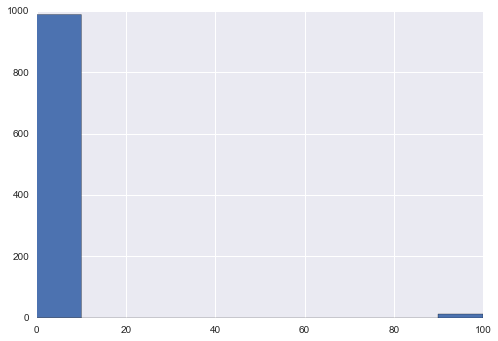

In [34]:
df_results.query('k==100')['true'].hist()

In [35]:
df_results.groupby(['k']).mean()

,sum,threshold,true
k,,,
100,1.166583,1.100000,1.200000
800,1.016613,1.037500,0.825000
6400,1.124038,1.096875,1.007812
13500,1.080150,1.050370,0.950370
108100,1.079148,1.053747,0.940241
864800,1.086390,1.063263,0.951735


In [36]:
df_results.groupby(['k']).std()

,sum,threshold,true
k,,,
100,8.242614,10.435464,10.893974
800,2.523244,3.539756,3.105079
6400,0.967050,1.255692,1.219936
13500,0.649441,0.864682,0.826235
108100,0.230559,0.312717,0.306673
864800,0.084183,0.111802,0.105094


### More Subsets

In [25]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from analysis.load_utils import load_diffs

In [27]:
d = load_diffs()

In [32]:
df_test = pd.read_csv('../../data/annotations/split/test/annotations.tsv', sep = '\t')
df_test = df_test.query("sample=='random'").drop_duplicates(subset='rev_id')[['rev_id', 'clean_diff']]
df_test = d['annotated'].merge(df_test, how = 'inner', on = 'rev_id')
df_test['pred_attack'] = (df_test['pred_attack_score_uncalibrated'] > dev_er_t).astype(int)

In [168]:
d1 = df_test[['ns', 'year', 'author_anon', 'user_id', 'user_text', 'clean_diff' ]].copy()
d1['source'] = 'crowd'
d1['attack'] = df_test.attack * 100


d2 = df_test[['ns', 'year', 'author_anon', 'user_id', 'user_text', 'clean_diff' ]].copy()
d2['source'] = 'model'
d2['attack'] = df_test.pred_attack * 100

d = pd.concat([d1, d2])

d['logged_in'] =  d['author_anon'].apply(lambda x: not x)
d['thank'] = d['clean_diff'].apply(lambda x: 'thank' in x.lower())

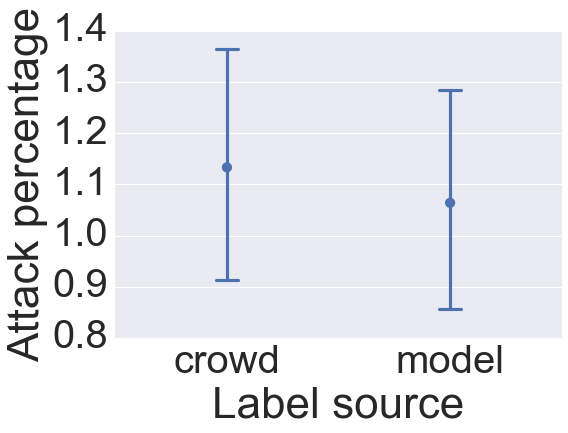

In [170]:
sns.set(font_scale=4)

g = sns.pointplot(data= d, x = 'source', y = 'attack', dodge=0.15, capsize=.1, linestyles=[ ""], )
plt.ylabel('Attack percentage')
plt.xlabel('Label source')
plt.savefig('../../paper/figs/sanity_check.png',bbox_inches='tight')

In [171]:
d_tmp1 = d.query("source == 'crowd'").copy()
d_tmp1['x'] = 'crowd'
d_tmp2 = d.query("source == 'model'").copy()
d_tmp2['x'] = 'model'

In [172]:
d_tmp3 = d[:2].copy()
d_tmp3['x'] = 'crowd'
d_tmp3['attack'][0] = 0.7
d_tmp3['x'][0] = 'model'
d_tmp3['attack'][1] = 0.7
d_tmp3['x'][1] = 'crowd'


In [173]:
d_temp = pd.concat([d_tmp1, d_tmp2, d_tmp3])

In [174]:
d_temp['x'].value_counts()

crowd    8649
model    8649
Name: x, dtype: int64

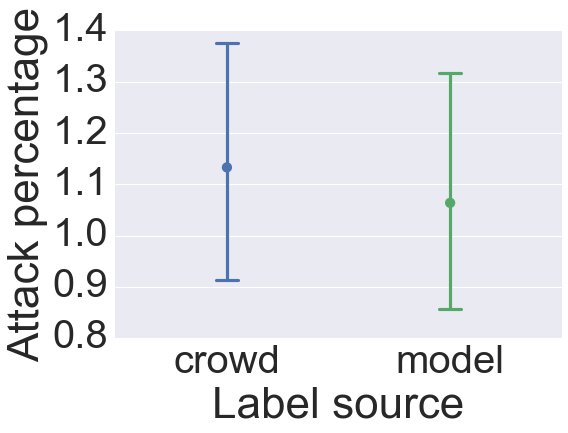

In [176]:
ax = sns.pointplot(data= d_temp, x = 'x', y = 'attack', hue = 'source', capsize=.1,linestyles=[" ", ""] )
ax.legend_.remove()
plt.ylim(0.8, 1.4)
plt.ylabel('Attack percentage')
plt.xlabel('Label source')
plt.savefig('../../paper/figs/sanity_check.png',bbox_inches='tight')

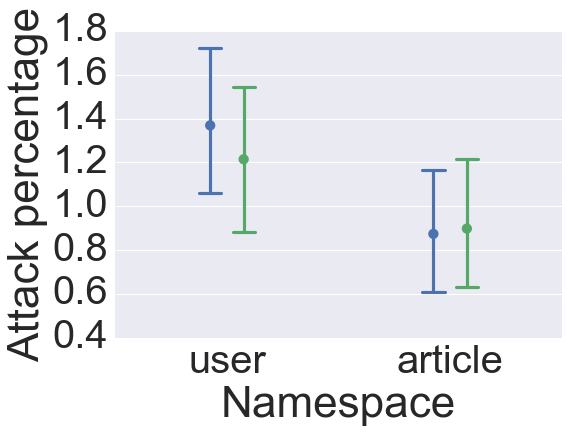

In [177]:
ax = sns.pointplot(data= d, x = 'ns', y = 'attack', hue = 'source', linestyles=[" ", ""], dodge=0.15, capsize=.1)
plt.xlabel('Namespace')
ax.legend_.remove()
plt.ylabel('Attack percentage')
plt.savefig('../../paper/figs/sanity_check_ns.png',bbox_inches='tight')

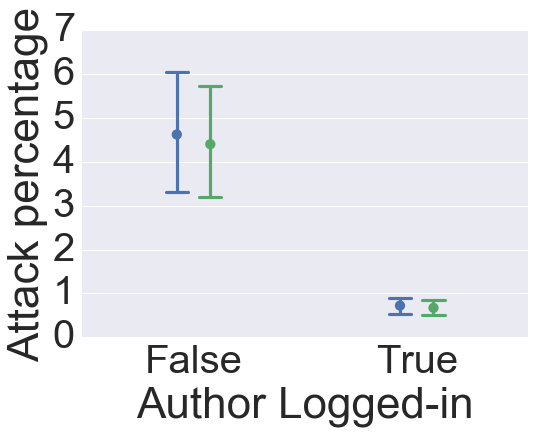

In [178]:
ax = sns.pointplot(data= d, x = 'logged_in', y = 'attack', hue = 'source', linestyles=[" ", ""], dodge=0.15, capsize=.1)
ax.legend_.remove()
plt.ylabel('Attack percentage')
plt.xlabel('Author Logged-in')
plt.savefig('../../paper/figs/sanity_check_anon.png', bbox_inches='tight')


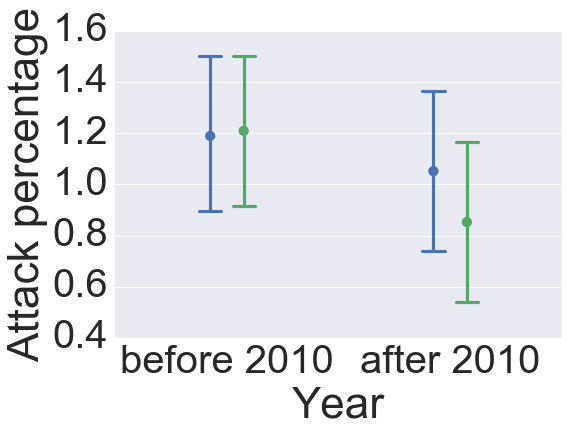

In [179]:
def map_year(y):
    if y < 2010:
        return 'before 2010'
    else:
        return 'after 2010'

d['com_year'] = d.year.apply(map_year)
ax = sns.pointplot(data= d, x = 'com_year', y = 'attack', hue = 'source', dodge=0.15, capsize=.1, linestyles=[" ", ""], order = ['before 2010', 'after 2010'])
ax.legend_.remove()
plt.ylabel('Attack percentage')
plt.xlabel('Year')

plt.savefig('../../paper/figs/sanity_check_year.png',bbox_inches='tight')


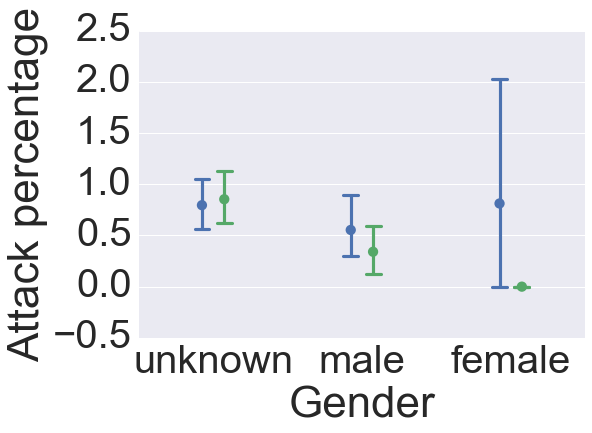

In [180]:
d_gender = pd.read_csv('../../data/genders.tsv', sep = '\t')
d_gender = d.merge(d_gender, how = 'left', on = 'user_id').query('not author_anon')
d_gender.gender.fillna('unknown', inplace = True)
ax = sns.pointplot(data= d_gender, x = 'gender', y = 'attack', hue = 'source', dodge=0.15, capsize=.1, linestyles=[" ", ""])
ax.legend_.remove()
plt.ylabel('Attack percentage')
plt.xlabel('Gender')
plt.savefig('../../paper/figs/sanity_check_gender.png', bbox_inches='tight')

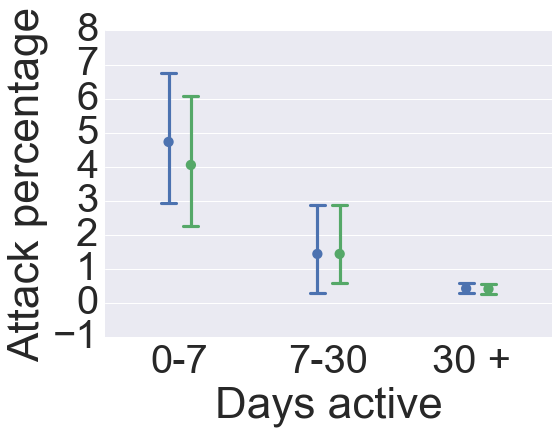

In [181]:
d_activity = pd.read_csv('../../data/long_term_users.tsv', sep = '\t')
d_activity = d.merge(d_activity, how = 'left', on = 'user_text').query('not author_anon')
d_activity.num_days.fillna(0, inplace = True)


def map_activity(a):
    if a < 8:
        return '0-7'
    elif a < 31:
        return '7-30'
    else:
        return '30 + '

d_activity['Days active'] = d_activity.num_days.apply(map_activity)


ax = sns.pointplot(data= d_activity, x = 'Days active', y = 'attack', hue = 'source',dodge=0.15, capsize=.1, linestyles=[" ", ""], order = ['0-7','7-30', '30 + ' ])
ax.legend_.remove()
plt.ylabel('Attack percentage')
plt.savefig('../../paper/figs/sanity_check_activity.png',bbox_inches='tight')


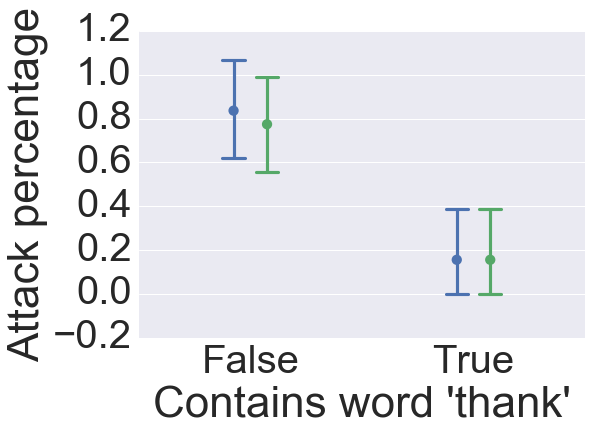

In [182]:
ax = sns.pointplot(data= d_activity, x = 'thank', y = 'attack', hue = 'source',dodge=0.15, capsize=.1, linestyles=[" ", ""])
ax.legend_.remove()
plt.ylabel('Attack percentage')
plt.xlabel("Contains word 'thank'")
plt.savefig('../../paper/figs/sanity_check_thank.png',bbox_inches='tight')


### Get  Dev + Test Equal Error Threshold

In [195]:
X_test, y_test_oh = assemble_data(data, 'comments', 'empirical_dist', splits = ['test', 'dev'], samples = ['random'])
y_test_pred = model.predict_proba(X_test)

0.424823 0.00342010260308 0.635135135135
0.429155 0.632653061224 0.628378378378


(0.6, 0.7)

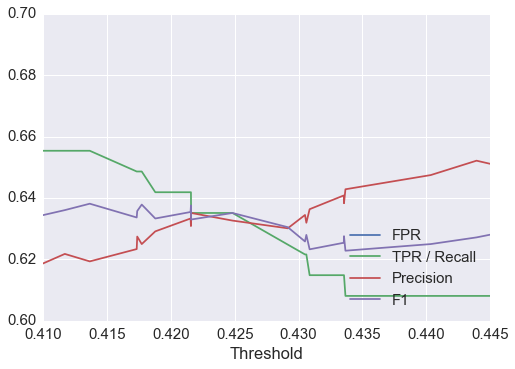

In [204]:
from ngram import two_class_combo_plotter
sns.set(font_scale=1.5)
two_class_combo_plotter(y_test_oh, y_test_pred)
plt.xlim(0.41, 0.445)
plt.ylim(0.6, 0.7)